In [1]:
import gc
import os
import sys

from typing import List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import nvidia.dali as dali
from nvidia.dali.plugin.pytorch import DALIGenericIterator

In [2]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
DATA_DIR = os.path.join(BASE_DIR, 'data/dfdc-videos')

sys.path.insert(0, SRC_DIR)

In [3]:
from dataset.utils import read_labels

In [4]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [5]:
class VideoPipe(dali.pipeline.Pipeline):
    def __init__(self, file_list: str, seq_len=30, stride=10, 
                 batch_size=1, num_threads=1, device_id=0):
        super(VideoPipe, self).__init__(
            batch_size, num_threads, device_id, seed=3)
        
        self.input = dali.ops.VideoReader(
            device='gpu', file_list=file_list, sequence_length=seq_len, 
            stride=stride, shard_id=0, num_shards=1)

    def define_graph(self):
        output, labels = self.input(name='reader')
        return output, labels
    
    
def get_file_list(df: pd.DataFrame, start: int, end: int, 
                  base_dir:str=DATA_DIR) -> List[str]:
    path_fn = lambda row: os.path.join(base_dir, row.dir, row.name)
    return df.iloc[start:end].apply(path_fn, axis=1).values.tolist()


def write_file_list(files, path='./file_list.txt'):    
    with open(path, mode='w') as h:
        for i, f in enumerate(files):
            h.write(f'{f} {i}\n')

In [6]:
def get_files_diff_chunks(
        df: pd.DataFrame, base_dir:str=DATA_DIR) -> List[str]:
    chunks = df['dir'].unique()
    files = []
    for chunk in chunks:
        row = df[df['dir']==chunk].iloc[0]
        path = os.path.join(base_dir, row.dir, row.name)
        files.append(path)
    return files


def build_iter(files):
    pipe = VideoPipe(files, seq_len=30, stride=11)
    pipe.build()
    data_iter = DALIGenericIterator([pipe], ['images'], len(files), dynamic_shape=True)
    return data_iter

In [7]:
df = read_labels(DATA_DIR, chunk_dirs=['dfdc_train_part_49'])

In [8]:
# files = get_files_diff_chunks(df)
start = 2700
end = start + 300
files = get_file_list(df, start, end)
list_path = './lel_kek_cheburek.txt'
write_file_list(files, path=list_path)

In [9]:
pipe = VideoPipe(list_path, seq_len=30, stride=10, device_id=1)

In [10]:
pipe.build()
i = 0

In [11]:
data_iter = DALIGenericIterator([pipe], ['images', 'label'], len(files), dynamic_shape=True)

In [12]:
def next_sample(data_iter):
    out = next(data_iter)[0]
    return out['images'].cpu().numpy(), out['label'].item()

In [13]:
frame_idxs = [0,1,2,14,15,16,27,28,29]
i = 0

266 /home/dmitry/projects/dfdc/data/dfdc-videos/dfdc_train_part_49/azmheosoed.mp4


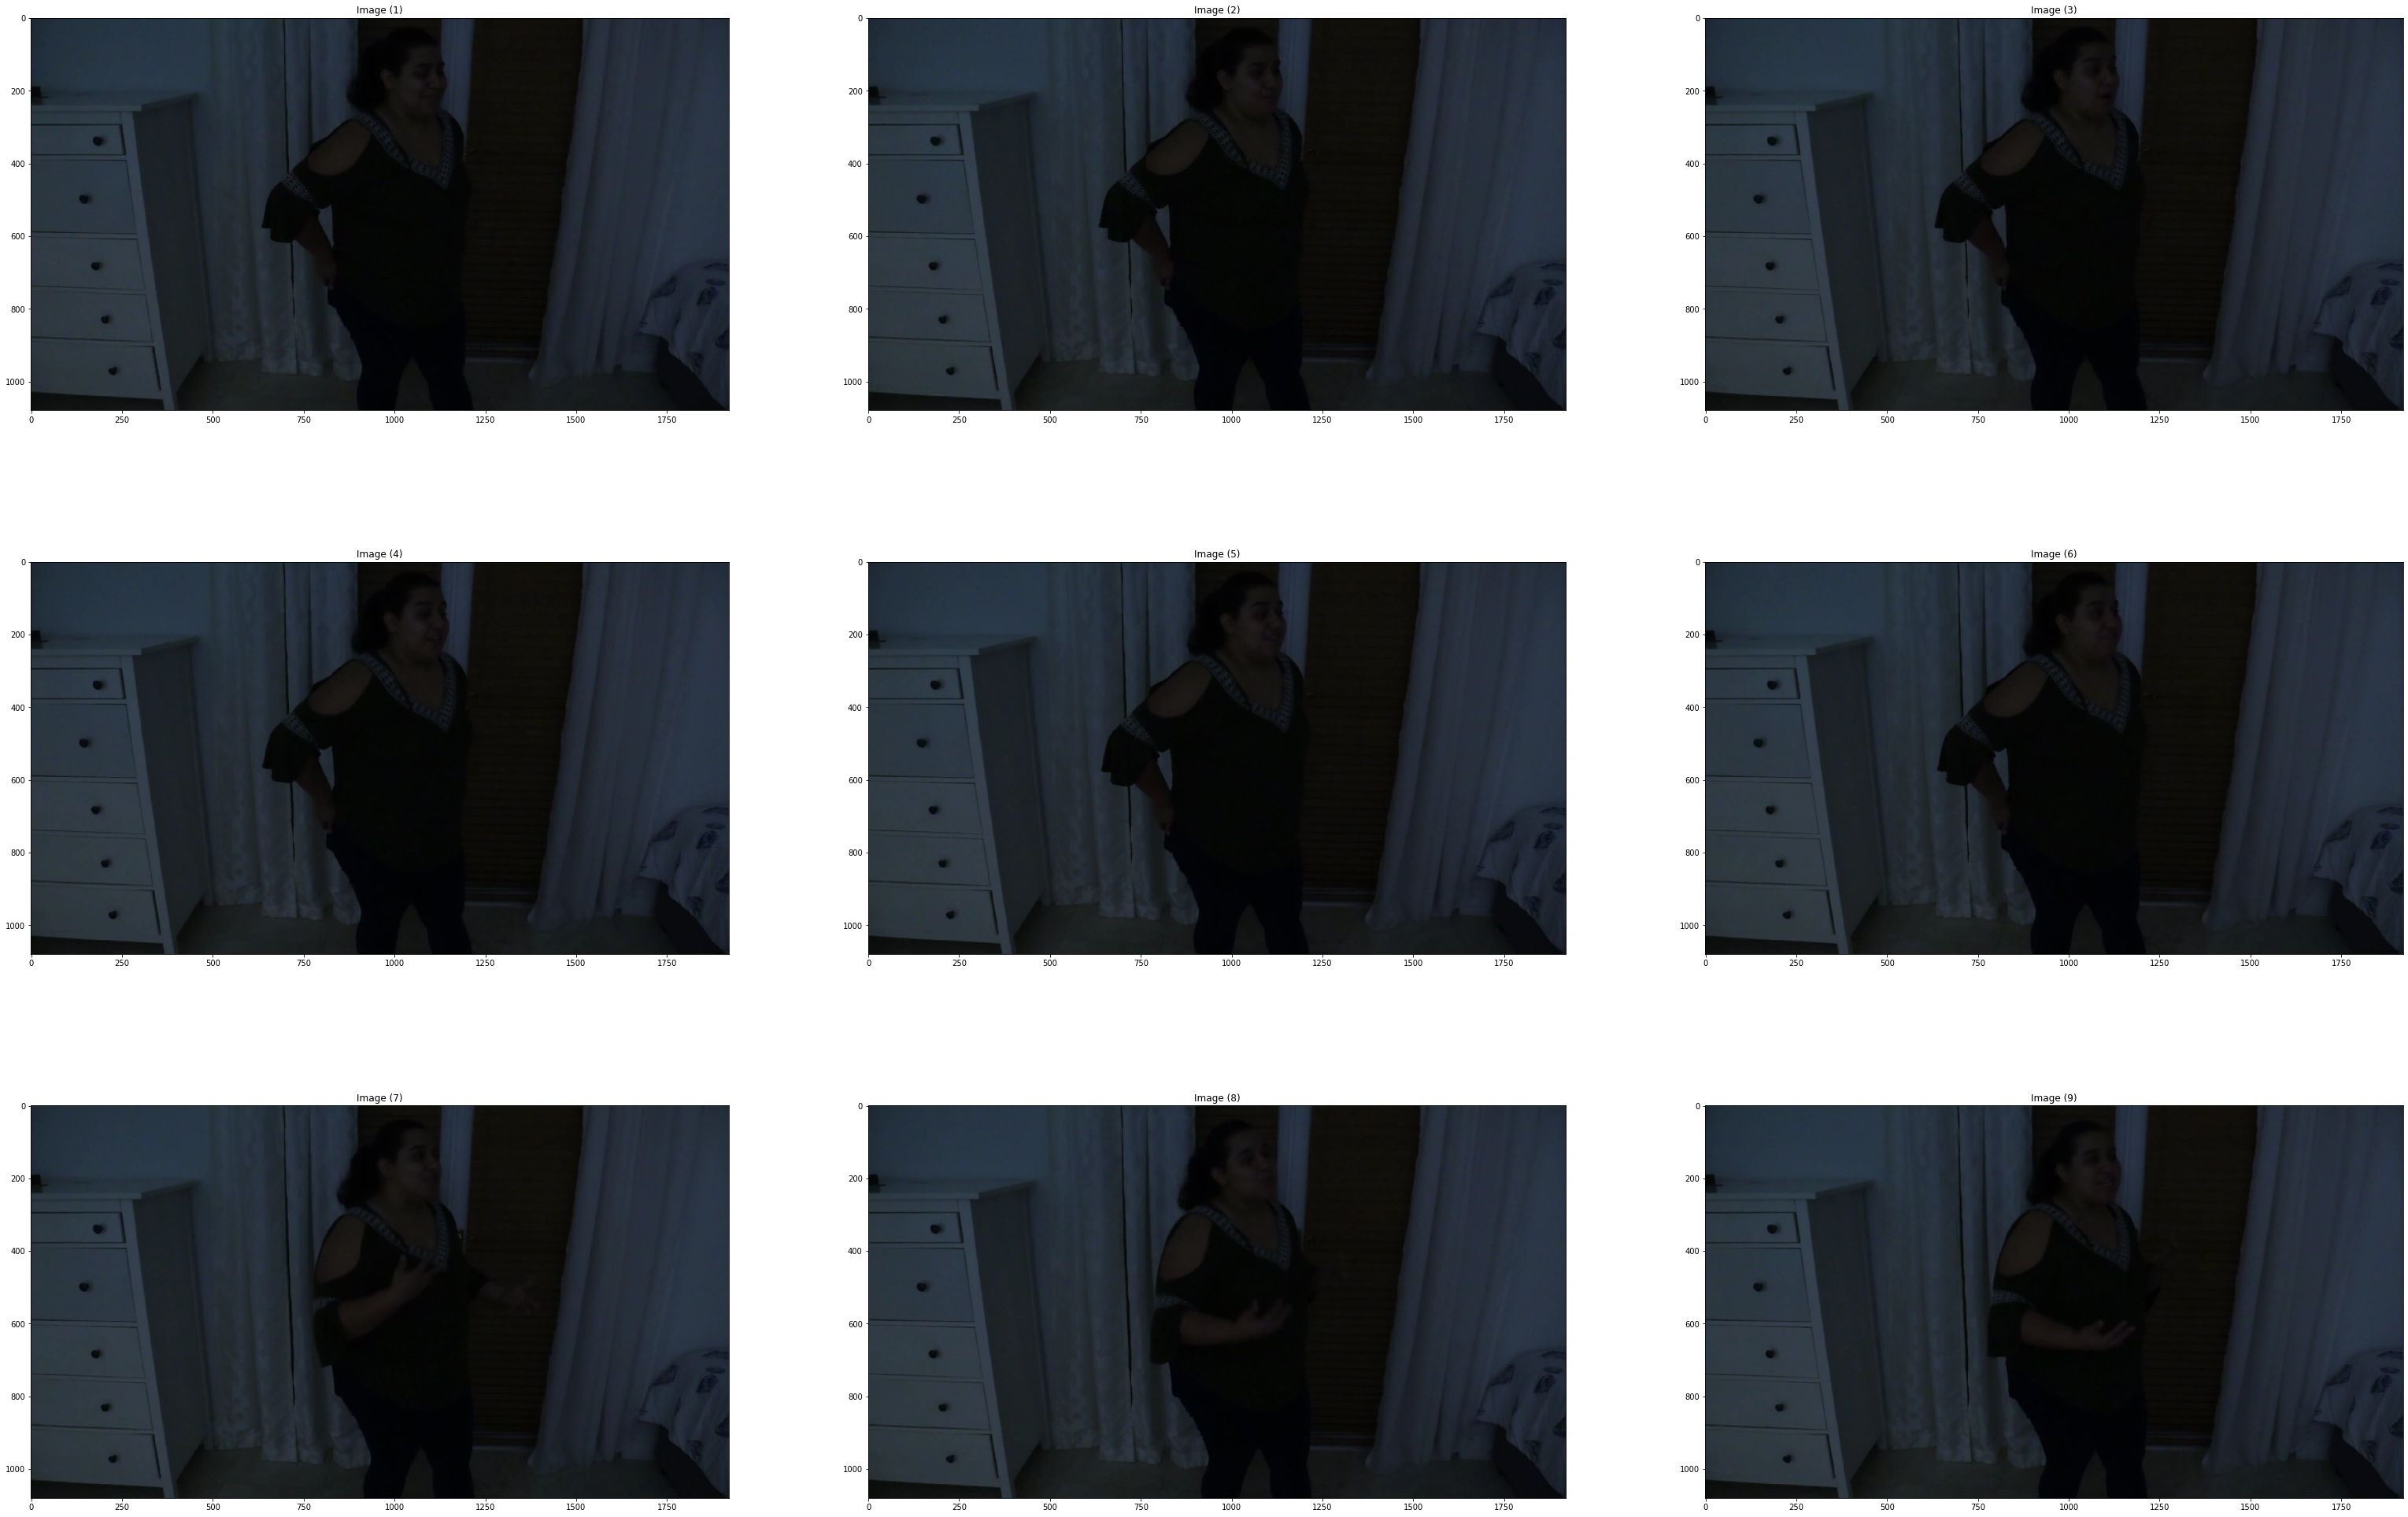

In [14]:
images, idx = next_sample(data_iter)
print(idx, files[idx])
show_images(images[0, frame_idxs], cols=3)

In [15]:
# sys.path.insert(0, SRC_DIR)
# from sample.reader import VideoReader

In [16]:
# reader = VideoReader()

In [17]:
# i = 0

In [18]:
# print(i)
# sample, frames = reader.read_frames(files[i], 30)
# num_frames = len(sample)
# print(f'Num frames: {num_frames}')
# frame_idxs_fixed = [f for f in frame_idxs if f < len(sample)]
# show_images(sample[frame_idxs_fixed], cols=3)
# i += 1